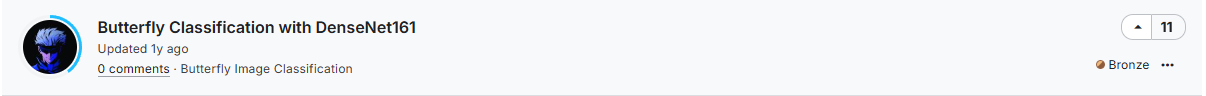

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import os
import pandas as pd
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_path = 'D:\code_study\ML_CODE\dataSets\Butterfly Image Classification'

In [6]:
data_train = f'{data_path}/train'
data_test = f'{data_path}/test'

csv_file_train = f'{data_path}/Training_set.csv'
csv_file_test = f'{data_path}/Testing_set.csv'

In [7]:
# Load the data
train_data = pd.read_csv(csv_file_train)
test_data = pd.read_csv(csv_file_test)

# Encode labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [8]:
class ButterflyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.dataframe.iloc[idx, 0])

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = transforms.ToPILImage()(image)  # Convert NumPy array to PIL Image
            image = self.transform(image)

        return image, label

In [9]:
# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = ButterflyDataset(dataframe=train_data, data_dir=data_train, transform=data_transform)
val_dataset = ButterflyDataset(dataframe=val_data, data_dir=data_train, transform=data_transform)
test_dataset = ButterflyDataset(dataframe=test_data, data_dir=data_test, transform=data_transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [10]:
# Load pre-trained DenseNet-161 model
model = models.densenet161(pretrained=True)

# Modify the classifier for binary classification
model.classifier = nn.Linear(model.classifier.in_features, len(label_encoder.classes_))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_labels = []
        val_predictions = []

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(val_labels, val_predictions)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}")

c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\Leaper/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|██████████| 110M/110M [07:20<00:00, 263kB/s] 


KeyboardInterrupt: 

In [ ]:
if not train_data.empty and 'filename' in train_data.columns:
    indices_to_display = range(11)  # Show 10 images from index 0 to 10

    # Set up subplots
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i, ax in zip(indices_to_display, axes.flatten()):
        image_path_train = os.path.join(data_train, train_data['filename'].iloc[i])

        try:
            image_to_display_train = Image.open(image_path_train).convert('RGB')
            # Display the image using Matplotlib
            ax.imshow(image_to_display_train)
            
            # Map numerical label to class name using label encoder
            numerical_label = train_data['label'].iloc[i]
            class_name = label_encoder.classes_[numerical_label]
            
            ax.set_title(f"Class: {class_name}", fontsize=10)
            ax.axis('off')  # Remove axis labels
        except Exception as e:
            print(f"Error opening the training image: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("No images in the training dataset.")

Epoch 1 Training:   0%|          | 0/82 [00:00<?, ?it/s]


AttributeError: 'EfficientNet' object has no attribute 'extract_features'